## Investigating Abstracted Visual Concepts Learning with Deep Convolutional Neural Networks and Alternatives
***
Keen You  
keen.you@yale.edu

### Motivation

Deep neural networks are undoubtedly successful at many computer vision tasks. However, as mentioned in class, deep neural networks struggle with tasks that require learning abstracted visual concepts, such as the same-different relations.

The figures below diaplay a few examples of such task. A human judgement for such tasks should be consistent regardless of the positions of the shape. However, for a deep CNN, the prediction may be different if we change the positions of the shapes as the generated feature representation will be different.
![example1.png](example1.png)

Here is an even more extreme example. Human judgement will be unaffected by the background, but deep CNN will be significantly affected as the images are very different, even though the abstracted visual concepts and task (find shapes and compare) are identical.
![example2.png](example2.png)

This observation raises the question: what exactly are deep CNNs learning? 

Even though CNNs are inspired by the human vision system, it seems that humans and deep neural networks are learning different things: humans learn the underlying abstract visual concepts whereas deep neural networks learn a set of rich and complex features that are position and dataset specific.

### Project Overview

In this project, I want to investigate what deep CNNs are learning for tasks that require understanding of abstracted visual concepts and what alternative approaches there are.

Particularly, I want to further explore various counting star related tasks in homework 4 q6. 

In [108]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

In [109]:
sns.set_theme()

### Counting Stars

**Task: given image, predict the number of stars in the image.**

In [5]:
# load data
x1_train = np.load('../hw/Homework4/Q6_1_x_train.npy')
y1_train = np.load('../hw/Homework4/Q6_1_y_train.npy')

x1_test = np.load('../hw/Homework4/Q6_1_x_test.npy')
y1_test = np.load('../hw/Homework4/Q6_1_y_test.npy')

In [6]:
x1_train.shape, y1_train.shape, x1_test.shape, y1_test.shape

((12000, 64, 64, 1), (12000, 1), (5000, 64, 64, 1), (5000, 1))

In [11]:
# dataset visualization
# retrieve 5 images for each class from train
from collections import defaultdict
counts = defaultdict(int)
index = 0
images = defaultdict(list)
while sum(counts.values()) != 20:
    label = int(y1_train[index][0])
    if counts[label] != 5:
        counts[label] += 1
        # save index
        images[label].append(index)
    index += 1
images

defaultdict(list,
            {1: [0, 1, 2, 3, 4],
             2: [3000, 3001, 3002, 3003, 3004],
             4: [6000, 6001, 6002, 6003, 6004],
             5: [9000, 9001, 9002, 9003, 9004]})

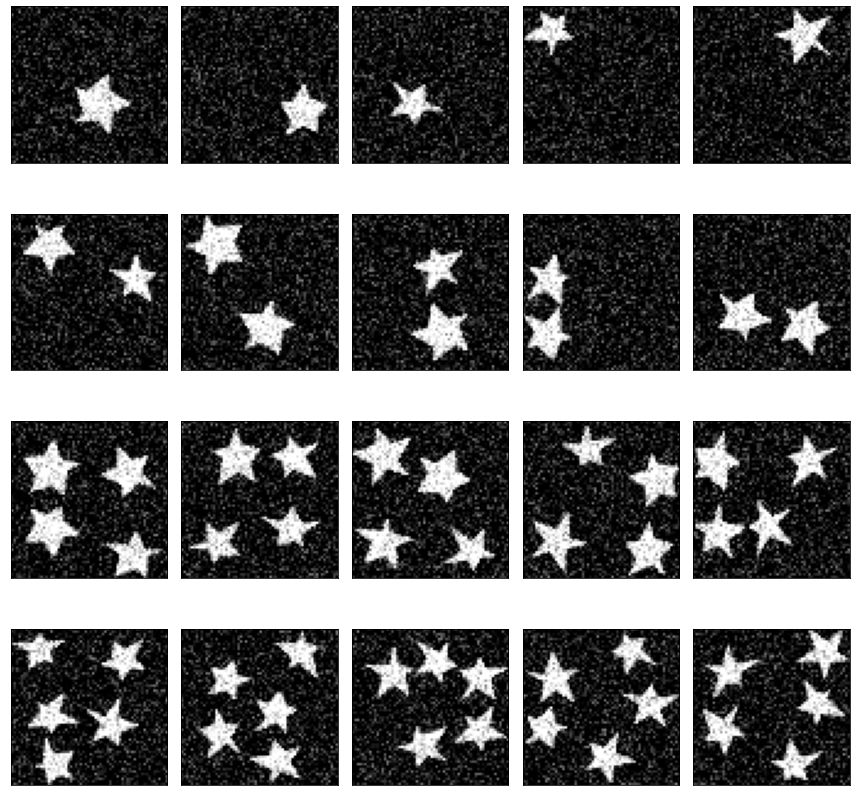

In [12]:
fig, axs = plt.subplots(4, 5, figsize=(12,12),
                        subplot_kw={'xticks': [], 'yticks': []})

for index, ax in enumerate(axs.flat):  
    if index < 10:
        label = index // 5 + 1
    else:
        label = (index + 5) // 5 + 1
    image_index = images[label].pop(0)
    image = x1_train[image_index]
    ax.imshow(image, cmap='gray')

plt.tight_layout()
plt.show()

In homework 4, a CNN achieves training performance of 0.1381 mse and testing performance of 0.1405. Accuracies are 0.89 and 0.82 respectively.

Visualization of the filters did not really provide much insights on what fetures the CNN is learning. Thus, I suspect that the CNN is relying on some other signals, such as the number of white pixels. I will verify the hypothesis now by 

- examining the number of white pixels for each class
- evaluating the plausibility of linear models
- CNN on zoomed in images (such that number of white pixels are similar for each class)

In [20]:
x1_test.shape

(5000, 64, 64, 1)

In [101]:
# remove last dimension
X_train = x1_train.reshape((12000, 64, 64))
X_test = x1_test.reshape((5000, 64, 64))
# normalize
X_train = X_train / 255.
X_test = X_test / 255.
# simple thresholding to identify object
# Extension: could use better object detection method
# but thresholding suffice for now
X_train = np.where(X_train > 0.5, 1, 0)
X_test = np.where(X_test > 0.5, 1, 0)

In [104]:
# Task 1: examine the number of white pixels for each class 
# count number of 1's in each image
white_pixel_counts = np.apply_along_axis(lambda img: np.count_nonzero(img),
                                        1, X_test.reshape(5000, 64 * 64))
count_df = pd.DataFrame({'label': pd.Series(y1_test.T[0]),
                        'white_pixel_count': pd.Series(white_pixel_counts)})

count_df.groupby('label').mean()

,white_pixel_count
label,
1.0,187.419
2.0,376.945
3.0,560.739
4.0,733.234
5.0,681.283


Seems like there is noticeable difference in the number of white pixels for different classes.

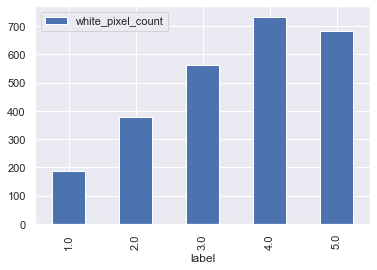

In [110]:
# plot mean for each class
count_df.groupby('label').mean().plot(kind='bar')
plt.show()

Seem like there is a linear relationship from 1 to 4?

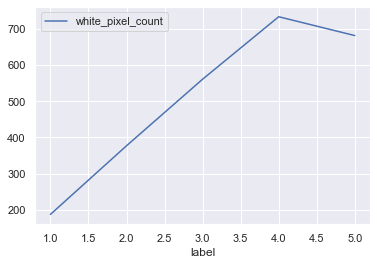

In [131]:
count_df.groupby('label').mean().plot(kind='line')
plt.show()

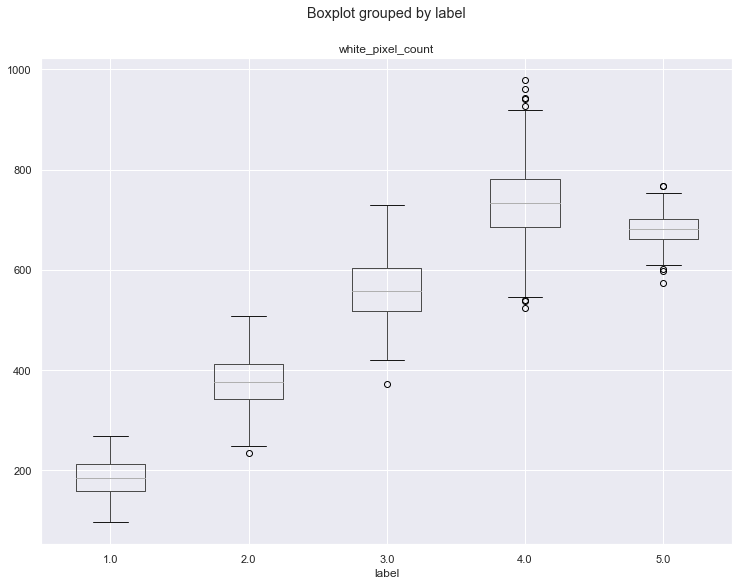

In [124]:
# box plot for each class
count_df.boxplot(column='white_pixel_count', by='label', figsize=(12,9))
plt.show()

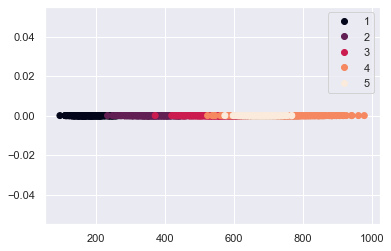

In [129]:
# scatter plot colored by label
scatter = plt.scatter(count_df['white_pixel_count'], np.zeros(len(count_df)), c=count_df['label'])
plt.legend(handles=scatter.legend_elements()[0], labels=[1,2,3,4, 5])
plt.show()

Apply the same steps to training set with missing 3

In [132]:
# count number of 1's in each image
white_pixel_counts = np.apply_along_axis(lambda img: np.count_nonzero(img),
                                        1, X_train.reshape(12000, 64 * 64))
count_df = pd.DataFrame({'label': pd.Series(y1_train.T[0]),
                        'white_pixel_count': pd.Series(white_pixel_counts)})

count_df.groupby('label').mean()

,white_pixel_count
label,
1.0,189.326667
2.0,373.577667
4.0,732.096667
5.0,681.938667


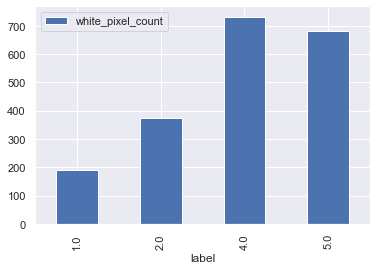

In [133]:
# plot mean for each class
count_df.groupby('label').mean().plot(kind='bar')
plt.show()

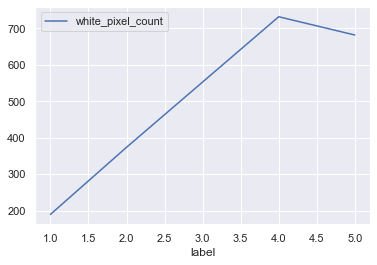

In [134]:
count_df.groupby('label').mean().plot(kind='line')
plt.show()

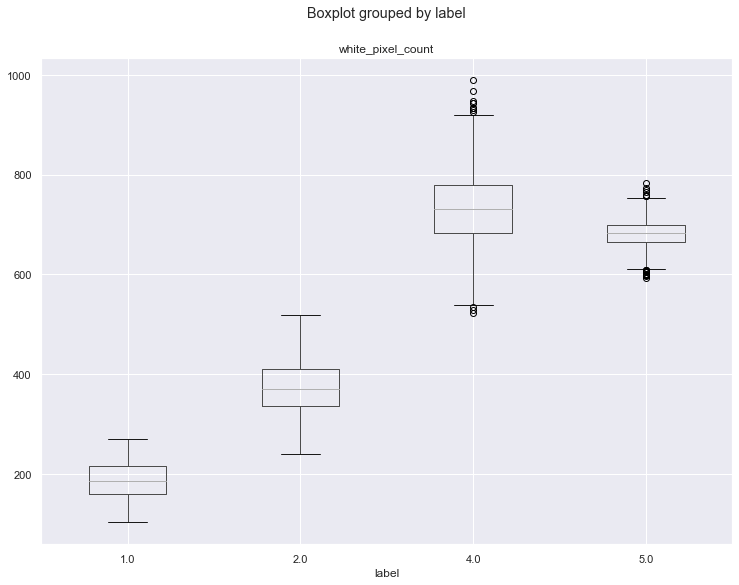

In [135]:
# box plot for each class
count_df.boxplot(column='white_pixel_count', by='label', figsize=(12,9))
plt.show()

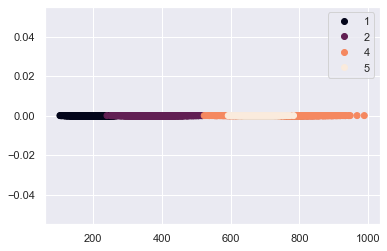

In [137]:
# scatter plot colored by label
scatter = plt.scatter(count_df['white_pixel_count'], np.zeros(len(count_df)), c=count_df['label'])
plt.legend(handles=scatter.legend_elements()[0], labels=[1,2,4,5])
plt.show()

Both training and testing sets exhibit the same trend. Some observations:

- The size of each star in images with 5 stars is smaller compared to that for other classes.
- This results in smaller number of white pixels for class 5 compared to class 4.
- This destroys the linear trend from class 1 through 4.
- Thus, a linear classifier may not suffice.

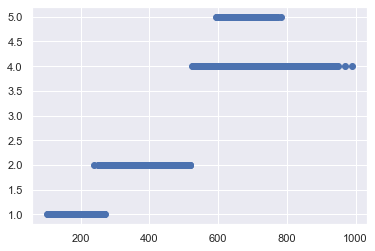

In [139]:
# Task 2: will linear models suffice?
# plot data points that we want to fit model on
plt.scatter(count_df['white_pixel_count'], count_df['label'])
plt.show()

We can see that the range of 5 stars is a subset of 4 stars, this will be a problem for linear classifiers based on only number of white pixels.

However, I will train a linear regression model on bag-of-features as a baseline performance to compare to CNN performance.

In [154]:
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error, accuracy_score

In [145]:
X_train = x1_train.reshape((12000, 64 * 64)) / 255.
y_train = y1_train.T[0]
X_test = x1_test.reshape((5000, 64 * 64)) / 255.
y_test = y1_test.T[0]

# normalize 
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
scaler = preprocessing.StandardScaler().fit(X_test)
X_test = scaler.transform(X_test)


In [146]:
reg = LinearRegression().fit(X_train, y_train)

In [155]:
train_pred = reg.predict(X_train)
train_mse = mean_squared_error(y_train, train_pred)
train_label_pred = np.array(np.round(train_pred), dtype=int)
train_accuracy = accuracy_score(y_train, train_label_pred)

In [157]:
print(f"Train mse: {train_mse}")
print(f"Train accuracy: {train_accuracy}")

Train mse: 0.15853926129306756
Train accuracy: 0.7915833333333333


In [159]:
test_pred = reg.predict(X_test)
test_mse = mean_squared_error(y_test, test_pred)
test_label_pred = np.array(np.round(test_pred), dtype=int)
test_accuracy = accuracy_score(y_test, test_label_pred)

In [161]:
print(f"Test mse: {test_mse}")
print(f"Test accuracy: {test_accuracy}")

Test mse: 0.40081380210632944
Test accuracy: 0.5724


The performances are significantly worse compared to CNN, which is expected. However, the performance is far better than random (20%). This suggests that without any concept of the shape star, the classifier is already doing decent at this task, let alone incorporating other superficial features and even features that are not observable for human eyes.

In addition to number of white pixels, other very likely features that CNN can make use of include positions of black pixels. For example, for images with 1 star, roughly three quadrants of the image are black, and none other class exhbitis this property. 

In general, for this task, there are many computational features that could be used to make predictions, rather than actually learning what a star shape is.

**Modified task**:   

For humans, a star shape is a star shape regardless of its size ie. translates to the same abstract visual concept. However, this will induce different feature representations in CNN. Is it going to affect predictions? We will find out now.

One crude way of doing this is to randomly zoom into some of the images, such that stars belonging to the same class do not always have the same size (number of white pixels). It is possible that part of some stars lie outside the images, but for a human, it should not affect judgement as one can still count the number of stars (if assuming all objects are stars).

In [194]:
import cv2

def zoom_in(img, zoom_factor=1.2):
    y_size = img.shape[0]
    x_size = img.shape[1]
    
    # define new boundaries
    x1 = int(0.5*x_size*(1-1/zoom_factor))
    x2 = int(x_size-0.5*x_size*(1-1/zoom_factor))
    y1 = int(0.5*y_size*(1-1/zoom_factor))
    y2 = int(y_size-0.5*y_size*(1-1/zoom_factor))
    
    # crop
    img_cropped = img[y1:y2,x1:x2]
    # scale
    return cv2.resize(img_cropped, None, fx=zoom_factor, fy=zoom_factor)
    

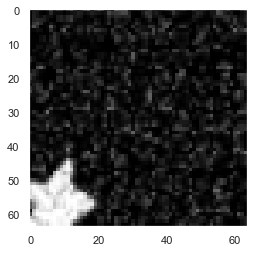

In [203]:
# a few examples
# one star
img = zoom_in(x1_train[100])
plt.imshow(img, cmap='gray')
plt.grid(None)
plt.show()

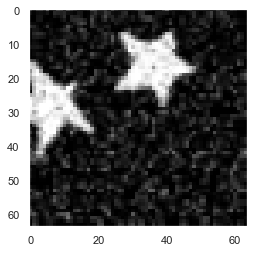

In [208]:
# two stars
img = zoom_in(x1_train[3436])
plt.imshow(img, cmap='gray')
plt.grid(None)
plt.show()

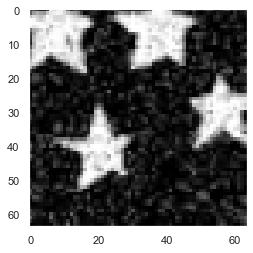

In [209]:
# four stars
img = zoom_in(x1_train[6160])
plt.imshow(img, cmap='gray')
plt.grid(None)
plt.show()

In [335]:
# randomly zoom in images
# 3000 per class
def batch_zoom(X_data, y, n_per_class=2000):
    X = np.array(X_data, copy=True)
    labels = np.unique(y)
    # group X by class
    for label in labels:
        current_X = X[y.T[0] == label]
        # randomly select indices to zoom in
        zoom_indices = np.random.choice(range(len(X)), n_per_class)
        for index in zoom_indices:
            X[index] = zoom_in(X[index])
    return X
    

In [336]:
X_train = batch_zoom(x1_train.reshape(len(x1_train), 64, 64), y1_train)
X_test = batch_zoom(x1_test.reshape(len(x1_test), 64, 64), y1_test)

In [340]:
# compare number of white pixels per class
discrete_train = np.where(X_train / 255. > 0.5, 1, 0)
white_pixel_counts = np.apply_along_axis(lambda img: np.count_nonzero(img),
                                        1, discrete_train.reshape(12000, 64 * 64) / 255.)
count_df = pd.DataFrame({'label': pd.Series(y1_train.T[0]),
                        'white_pixel_count': pd.Series(white_pixel_counts)})

count_df.groupby('label').mean()

,white_pixel_count
label,
1.0,240.082333
2.0,460.734333
4.0,884.890000
5.0,797.058667


Ideally, the average white pixel count for each class should be similar. This requires zooming onto the object regions, especially for one and two stars.

In [341]:
# some inspection
# retrieve 5 images for each class from train
from collections import defaultdict
counts = defaultdict(int)
index = 0
images = defaultdict(list)
while sum(counts.values()) != 20:
    label = int(y1_train[index][0])
    if counts[label] != 5:
        counts[label] += 1
        # save index
        images[label].append(index)
    index += 1
images

defaultdict(list,
            {1: [0, 1, 2, 3, 4],
             2: [3000, 3001, 3002, 3003, 3004],
             4: [6000, 6001, 6002, 6003, 6004],
             5: [9000, 9001, 9002, 9003, 9004]})

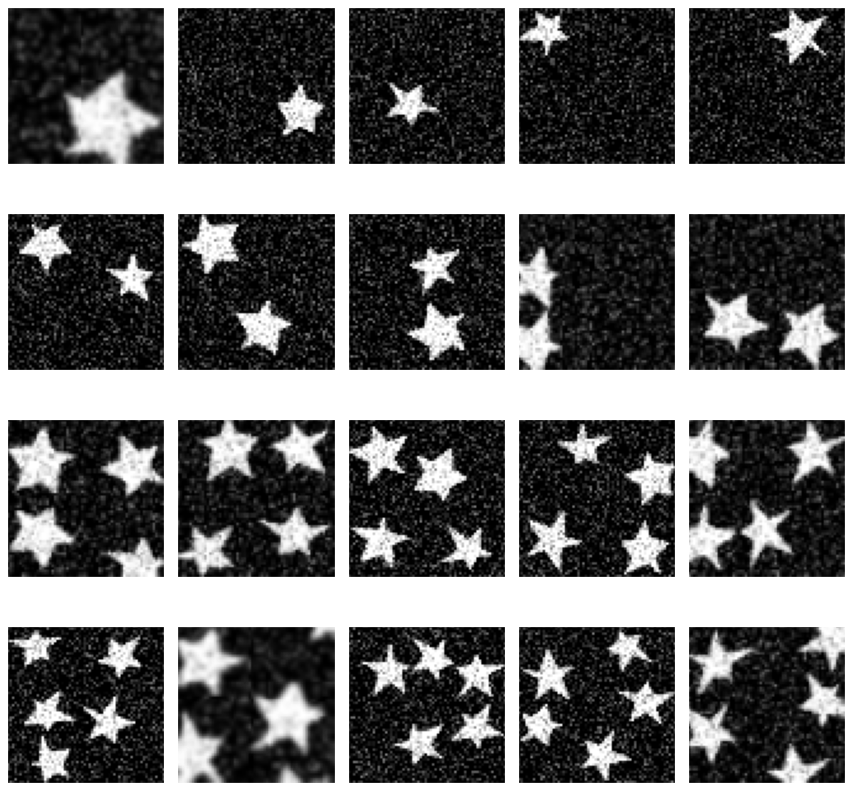

In [342]:
fig, axs = plt.subplots(4, 5, figsize=(12,12),
                        subplot_kw={'xticks': [], 'yticks': []})

for index, ax in enumerate(axs.flat):  
    if index < 10:
        label = index // 5 + 1
    else:
        label = (index + 5) // 5 + 1
    image_index = images[label].pop(0)
    image = X_train[image_index]
    ax.imshow(image, cmap='gray')

plt.tight_layout()
plt.show()

In [343]:
X_train = X_train.reshape(12000, 64, 64, 1)
X_test = X_test.reshape(5000, 64, 64, 1)
img_shape_full = (64, 64, 1)

In [350]:
# test on CNN with same configuration as hw4 Q6
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import InputLayer, Input
from tensorflow.python.keras.layers import Reshape, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.python.keras.layers import Conv2D, Dense, Flatten

model = Sequential()

model.add(Conv2D(kernel_size=5, strides=1, filters=32, padding='same',
                 activation='relu', name='layer_conv1', input_shape=img_shape_full))

model.add(MaxPooling2D(pool_size=2, strides=2))

model.add(Conv2D(kernel_size=5, strides=1, filters=32, padding='same',
                 activation='relu', name='layer_conv2'))
model.add(MaxPooling2D(pool_size=2, strides=2))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dense(32, activation='relu'))

# To do regression, use a linear activation for the final dense layer!
model.add(Dense(1, activation='linear'))

In [351]:
model.compile(optimizer='adam',
              loss='mse',
              metrics=['mae'])

In [352]:
history = model.fit(x=X_train,
          y=y_train,
          epochs=3, batch_size=100)

Epoch 1/3
  1/120 [..............................] - ETA: 33s - loss: 68.5182 - mae: 6.9409

2022-05-09 00:00:44.499305: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


120/120 [==============================] - 3s 19ms/step - loss: 234.0646 - mae: 2.2617
Epoch 2/3
120/120 [==============================] - 2s 19ms/step - loss: 0.1470 - mae: 0.2933
Epoch 3/3
120/120 [==============================] - 2s 19ms/step - loss: 0.1046 - mae: 0.2447


In [353]:
# evaluation
result = model.evaluate(X_test, y_test, batch_size=32, verbose=1)
for name, value in zip(model.metrics_names, result):
    print(name, value)

 22/157 [===>..........................] - ETA: 0s - loss: 0.0890 - mae: 0.2282

2022-05-09 00:00:54.395959: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


157/157 [==============================] - 1s 6ms/step - loss: 0.3365 - mae: 0.3868
loss 0.33653557300567627
mae 0.38675278425216675


In [354]:
# compare accuracy
# train accuracy
train_pred = model.predict(x=X_train)
train_pred = np.array(np.round(train_pred.T[0]), dtype=int)
train_accuracy = sum(train_pred == y_train.T[0]) / len(train_pred)

# test accuracy
test_pred = model.predict(x=X_test)
test_pred = np.array(np.round(test_pred.T[0]), dtype=int)
test_accuracy = sum(test_pred == y_test.T[0]) / len(test_pred)

print(f'Train accuracy: {train_accuracy}')
print(f'Test accuracy: {test_accuracy}')

2022-05-09 00:00:56.551655: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-09 00:00:57.856361: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Train accuracy: 0.247
Test accuracy: 0.1938


The performance on this dataset is significantly worse compare to original dataset. Performance on the original dataset is 0.89 on train and 0.82 on test.

This is expected from a computational perspective, but not expected from a abstract concept learning perspective. If someone gets the abstract concept of a star shape, or just a shape in general, it is expected that they are able to count the number of shapes even when images are zoomed in.

### Counting star tips

**Task: given image, predict the number of tips that the single "pointy star-like object" in the image has.**